In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import matplotlib.pyplot as plt

from s7_datasets import load_data_S7_1
from models import model_summary
from utils import train_S7,test_S7,plot_acc_loss_S7

c:\Users\Aai\anaconda3\envs\pytorch\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\Aai\anaconda3\envs\pytorch\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
use_cuda = torch.cuda.is_available()  # Check if CUDA (GPU support) is available
device = torch.device("cuda" if use_cuda else "cpu")  # Select GPU if available, otherwise fall back to CPU
device  # Display the selected device

device(type='cpu')

In [3]:
trainloader , testloader = load_data_S7_1()

In [4]:
# def plot_image(loader,no_images):
#     batch_data, batch_label = next(iter(loader))
#     _ = plt.figure()

#     for i in range(no_images):
#         plt.subplot(3,4,i+1)
#         plt.tight_layout()
#         plt.imshow(batch_data[i].squeeze(0), cmap='gray')
#         plt.title(batch_label[i].item())
#         plt.xticks([])
#         plt.yticks([])


# plot_image(trainloader,6)
# plot_image(testloader,6)

In [25]:
class S7_Model(nn.Module):
    def __init__(self):
        super(S7_Model, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, bias=False), 
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, padding=1),  
            nn.BatchNorm2d(4),
            nn.ReLU(),
        )
        # transition block 1
        self.trans_block1 = nn.Sequential(
            nn.MaxPool2d(2, 2), 
            nn.Conv2d(4, 16, 1), 
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),  
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, padding=1), 
            nn.ReLU(),  
            nn.BatchNorm2d(8),
            nn.Dropout(0.2)  
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(8, 4, kernel_size=1),
            nn.ReLU(),
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=1),
            nn.ReLU(),
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(8,10, kernel_size=1),
            nn.AdaptiveAvgPool2d(1),
        )
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=1)
        )

        self.dropout = nn.Dropout(0.25)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=8, kernel_size=3, padding=1),  
            nn.ReLU(),
        )
        
        # self.conv1x1_2 = nn.Sequential(
        #     nn.Conv2d(in_channels=8, out_channels=2, kernel_size=3, padding=1), 
        #     nn.BatchNorm2d(2),
        #     nn.ReLU(),
        # )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.trans_block1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)

        x = x.view(-1,10)  
        x = F.log_softmax(x, dim=1)
        return x


In [26]:

model = S7_Model()
model_summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
            Conv2d-4            [-1, 4, 28, 28]             292
       BatchNorm2d-5            [-1, 4, 28, 28]               8
              ReLU-6            [-1, 4, 28, 28]               0
         MaxPool2d-7            [-1, 4, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]              80
       BatchNorm2d-9           [-1, 16, 14, 14]              32
             ReLU-10           [-1, 16, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           2,320
      BatchNorm2d-12           [-1, 16, 14, 14]              32
             ReLU-13           [-1, 16, 14, 14]               0
        MaxPool2d-14             [-1, 1

In [27]:
model = S7_Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 15




for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_S7(model, device, trainloader, optimizer,criterion)
  scheduler.step()
  test_S7(model, device, testloader, criterion)
  


c:\Users\Aai\anaconda3\envs\pytorch\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


Train: Loss=0.3596 Batch_id=937 Accuracy=46.43: 100%|██████████| 938/938 [00:24<00:00, 38.66it/s]


Test set: Average loss: 0.0078, Accuracy: 8323/10000 (83.23%)

Epoch 2


Train: Loss=0.5095 Batch_id=937 Accuracy=86.82: 100%|██████████| 938/938 [00:27<00:00, 33.82it/s]


Test set: Average loss: 0.0031, Accuracy: 9465/10000 (94.65%)

Epoch 3


Train: Loss=0.0737 Batch_id=937 Accuracy=90.49: 100%|██████████| 938/938 [00:26<00:00, 34.76it/s]


Test set: Average loss: 0.0029, Accuracy: 9482/10000 (94.82%)

Epoch 4


Train: Loss=0.1117 Batch_id=937 Accuracy=91.81: 100%|██████████| 938/938 [00:26<00:00, 35.64it/s]


Test set: Average loss: 0.0026, Accuracy: 9515/10000 (95.15%)

Epoch 5


Train: Loss=0.2624 Batch_id=937 Accuracy=92.54: 100%|██████████| 938/938 [00:26<00:00, 35.94it/s]


Test set: Average loss: 0.0020, Accuracy: 9650/10000 (96.50%)

Epoch 6


Train: Loss=0.1738 Batch_id=937 Accuracy=94.30: 100%|██████████| 938/938 [00:26<00:00, 35.05it/s]


Test set: Average loss: 0.0016, Accuracy: 9724/10000 (97.24%)

Epoch 7


Train: Loss=0.1435 Batch_id=937 Accuracy=94.42: 100%|██████████| 938/938 [00:26<00:00, 35.54it/s]


Test set: Average loss: 0.0015, Accuracy: 9721/10000 (97.21%)

Epoch 8


Train: Loss=0.2810 Batch_id=937 Accuracy=94.66: 100%|██████████| 938/938 [00:26<00:00, 35.88it/s]


Test set: Average loss: 0.0015, Accuracy: 9731/10000 (97.31%)

Epoch 9


Train: Loss=0.1237 Batch_id=937 Accuracy=94.76: 100%|██████████| 938/938 [00:26<00:00, 35.99it/s]


Test set: Average loss: 0.0014, Accuracy: 9720/10000 (97.20%)

Epoch 10


Train: Loss=0.2169 Batch_id=937 Accuracy=94.64: 100%|██████████| 938/938 [00:26<00:00, 35.75it/s]


Test set: Average loss: 0.0014, Accuracy: 9734/10000 (97.34%)

Epoch 11


Train: Loss=0.2710 Batch_id=937 Accuracy=94.85: 100%|██████████| 938/938 [00:26<00:00, 35.73it/s]


Test set: Average loss: 0.0014, Accuracy: 9739/10000 (97.39%)

Epoch 12


Train: Loss=0.0206 Batch_id=937 Accuracy=94.90: 100%|██████████| 938/938 [00:26<00:00, 35.54it/s]


Test set: Average loss: 0.0014, Accuracy: 9743/10000 (97.43%)

Epoch 13


Train: Loss=0.0386 Batch_id=937 Accuracy=94.79: 100%|██████████| 938/938 [00:26<00:00, 35.40it/s]


Test set: Average loss: 0.0014, Accuracy: 9745/10000 (97.45%)

Epoch 14


Train: Loss=0.0982 Batch_id=937 Accuracy=94.87: 100%|██████████| 938/938 [00:26<00:00, 35.44it/s]


Test set: Average loss: 0.0014, Accuracy: 9735/10000 (97.35%)

Epoch 15


Train: Loss=0.1678 Batch_id=937 Accuracy=94.68: 100%|██████████| 938/938 [00:24<00:00, 37.86it/s]


Test set: Average loss: 0.0014, Accuracy: 9749/10000 (97.49%)



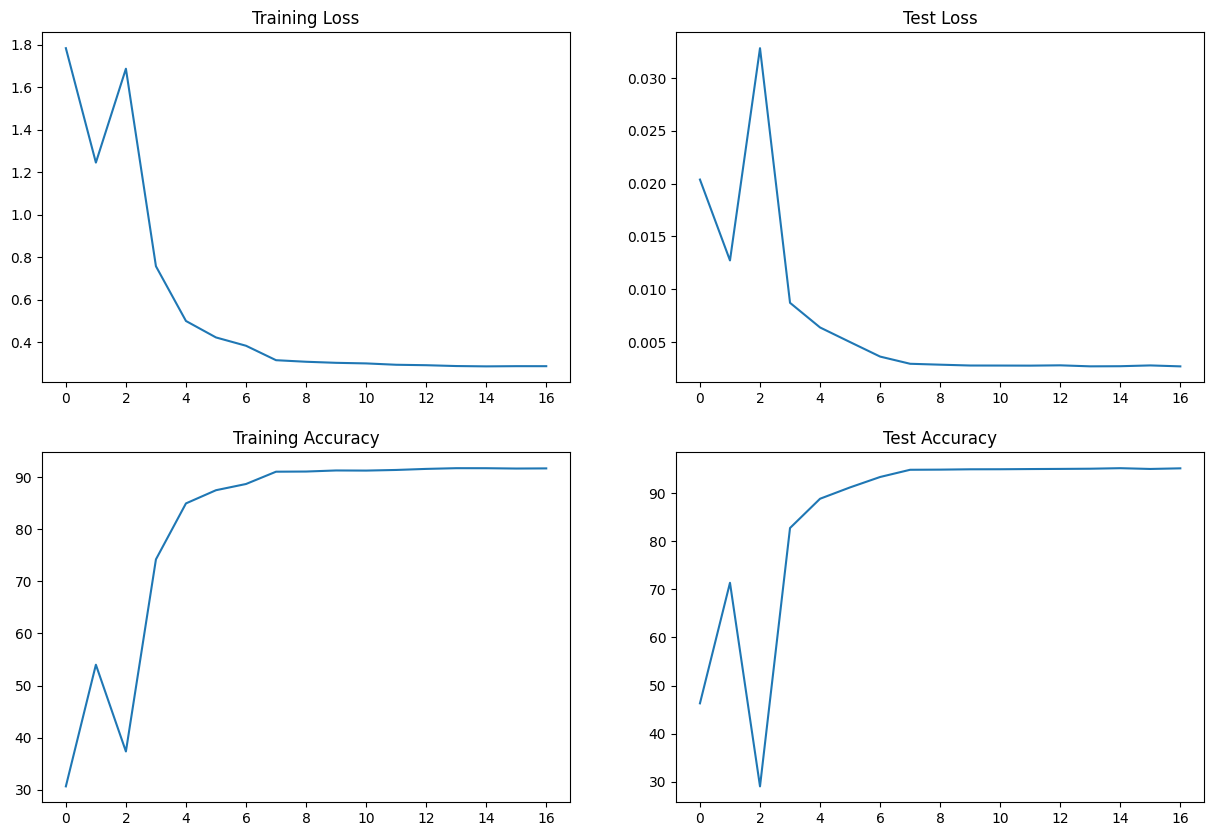

In [22]:
plot_acc_loss_S7()